# Suitability Filter Experiments

In [1]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights, resnet50

from suitability.filter import suitability
from suitability.baselines.ac import AverageConfidence
from suitability.baselines.atc import AverageThresholdConfidence
from suitability.baselines.doc import DifferenceOfConfidence

importlib.reload(suitability)

from suitability.filter.suitability import SuitabilityFilter

random.seed(32)
np.random.seed(32)

## Define data and model

In [2]:
root_dir = "/mfsnic/datasets/imagenet/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize(size=(232, 232), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),  # Convert to Tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

imagenet_data = torchvision.datasets.ImageNet(root_dir, split="val", transform=transform)
test, regressor, user = random_split(imagenet_data, [0.25, 0.25, 0.5])
test_data = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)
regressor_data = DataLoader(regressor, batch_size=64, shuffle=True, num_workers=4)

## Initialize suitability filter

In [3]:
suitability_filter = SuitabilityFilter(model, test_data, regressor_data, device)
test_features, test_corr = suitability_filter.get_features(test_data)
suitability_filter.train_regressor()

average_confidence = AverageConfidence(model, test_data, device)
average_threshold_confidence = AverageThresholdConfidence(model, test_data, device)
difference_of_confidence = DifferenceOfConfidence(model, test_data, device)

## Evaluate the suitability filter

### IID Evaluation

In [5]:
dataloader = DataLoader(user, batch_size=64, shuffle=False, num_workers=4)
all_user_features, all_user_corr = suitability_filter.get_features(dataloader)

In [9]:
def split_dataset_into_folds(correctness, target_accuracies):
    # Define target accuracies
    n_subsets = len(target_accuracies)
    total_samples = len(correctness)
    
    # Shuffle the indices and the correctness array
    indices = np.random.permutation(total_samples)
    shuffled_correctness = correctness[indices]

    # Initialize subsets
    folds = []
    subsets_correctness = []

    start_idx = 0
    for i, target_accuracy in enumerate(target_accuracies):
        # Calculate the number of correct and incorrect samples needed for the subset
        subset_size = total_samples // n_subsets
        n_correct = int(subset_size * target_accuracy)
        n_incorrect = subset_size - n_correct

        # Find the correct/incorrect samples in the shuffled data
        remaining_correct_indices = np.where(shuffled_correctness[start_idx:] == 1)[0]
        remaining_incorrect_indices = np.where(shuffled_correctness[start_idx:] == 0)[0]

        # Adjust n_correct and n_incorrect based on available samples
        n_correct = min(n_correct, len(remaining_correct_indices))
        n_incorrect = min(n_incorrect, len(remaining_incorrect_indices))

        # Get the actual indices for the current subset
        correct_indices = remaining_correct_indices[:n_correct]
        incorrect_indices = remaining_incorrect_indices[:n_incorrect]

        # Get the final indices for the current subset
        subset_indices = np.concatenate((correct_indices, incorrect_indices)) + start_idx
        
        # Extract the correctness for the current subset
        folds.append(indices[subset_indices])
        subsets_correctness.append(np.mean(shuffled_correctness[subset_indices]))

        # Move the start index forward
        start_idx += len(subset_indices)

    return folds, subsets_correctness

In [50]:
# Construct suitability filter
num_random_tries = 100
target_accuracies = np.arange(0.78, 0.83, 0.005)
num_folds = len(target_accuracies)

acs = np.zeros((num_random_tries, num_folds))
corrs = np.zeros((num_random_tries, num_folds))
p_vals = np.zeros((num_random_tries, num_folds))
p_vals_margin1 = np.zeros((num_random_tries, num_folds))
p_vals_margin2 = np.zeros((num_random_tries, num_folds))
p_vals_margin3 = np.zeros((num_random_tries, num_folds))
p_vals_margin4 = np.zeros((num_random_tries, num_folds))
p_vals_2k_samples = np.zeros((num_random_tries, num_folds))
p_vals_15k_samples = np.zeros((num_random_tries, num_folds))
p_vals_1k_samples = np.zeros((num_random_tries, num_folds))

for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(all_user_corr, target_accuracies=target_accuracies)

    for i, fold_indices in enumerate(folds):
        # Select features for the current fold
        user_features = all_user_features[fold_indices]
        np.random.shuffle(user_features)
        user_corr = all_user_corr[fold_indices]

        acs[j, i] = np.mean(user_features, axis=0)[1]
        corrs[j, i] = np.mean(user_corr)
        test = suitability_filter.suitability_test(user_features=user_features)
        p_vals[j, i] = test['p_value']
        test1 = suitability_filter.suitability_test(user_features=user_features, margin=0.01)
        p_vals_margin1[j, i] = test1['p_value']
        test2 = suitability_filter.suitability_test(user_features=user_features, margin=0.02)
        p_vals_margin2[j, i] = test2['p_value']
        test3 = suitability_filter.suitability_test(user_features=user_features, margin=0.03)
        p_vals_margin3[j, i] = test3['p_value']
        test4 = suitability_filter.suitability_test(user_features=user_features, margin=0.04)
        p_vals_margin4[j, i] = test4['p_value']
        p_vals_2k_samples[j, i] = suitability_filter.suitability_test(user_features=user_features[:2000])['p_value']
        p_vals_15k_samples[j, i] = suitability_filter.suitability_test(user_features=user_features[:1500])['p_value']
        p_vals_1k_samples[j, i] = suitability_filter.suitability_test(user_features=user_features[:1000])['p_value']


In [52]:
test_ac = np.mean(test_features, axis=0)[1]
test_corr = np.mean(test_corr)

In [53]:
def get_fpr_fnr(actual_accuracies, p_vals, alpha=0.05):
    fpr = 0
    fnr = 0
    for i, acc in enumerate(actual_accuracies):
        if acc < test_corr:
            fpr += np.sum(p_vals[:, i] < alpha) / (p_vals.shape[0]*p_vals.shape[1])
        else:
            fnr += np.sum(p_vals[:, i] >= alpha) / (p_vals.shape[0]*p_vals.shape[1])
    return fpr, fnr

In [54]:
fpracs, fnracs = 0, 0

for i, acc in enumerate(actual_accuracies):
    if acc < test_corr:
        fpracs += np.sum(acs[:, i] >= test_ac) / (acs.shape[0]*acs.shape[1])
    else:
        fnracs += np.sum(acs[:, i] < test_ac) / (acs.shape[0]*acs.shape[1])

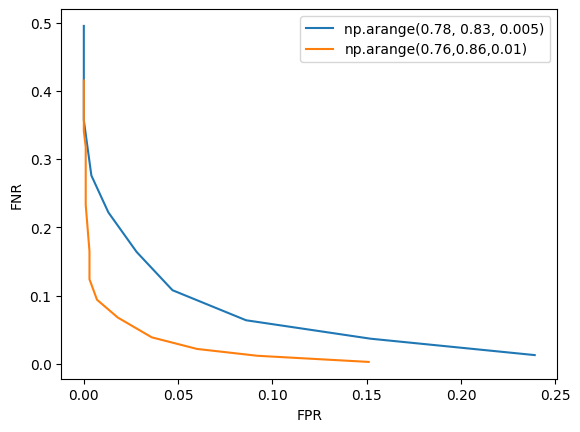

In [57]:
fprs = []
fprs_margin1 = []
fprs_margin2 = []
fprs_margin3 = []
fprs_margin4 = []
fprs_2k_samples = []
fprs_15k_samples = []
fprs_1k_samples = []
fnrs = []
fnrs_margin1 = []
fnrs_margin2 = []
fnrs_margin3 = []
fnrs_margin4 = []
fnrs_2k_samples = []
fnrs_15k_samples = []
fnrs_1k_samples = []


for a in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    fpr, fnr = get_fpr_fnr(actual_accuracies, p_vals, alpha=a)
    fprs.append(fpr)
    fnrs.append(fnr)
    fpr1, fnr1 = get_fpr_fnr(actual_accuracies, p_vals_margin1, alpha=a)
    fprs_margin1.append(fpr1)
    fnrs_margin1.append(fnr1)
    fpr2, fnr2 = get_fpr_fnr(actual_accuracies, p_vals_margin2, alpha=a)
    fprs_margin2.append(fpr2)
    fnrs_margin2.append(fnr2)
    fpr3, fnr3 = get_fpr_fnr(actual_accuracies, p_vals_margin3, alpha=a)
    fprs_margin3.append(fpr3)
    fnrs_margin3.append(fnr3)
    fpr4, fnr4 = get_fpr_fnr(actual_accuracies, p_vals_margin4, alpha=a)
    fprs_margin4.append(fpr4)
    fnrs_margin4.append(fnr4)
    fpr2k, fnr2k = get_fpr_fnr(actual_accuracies, p_vals_2k_samples, alpha=a)
    fprs_2k_samples.append(fpr2k)
    fnrs_2k_samples.append(fnr2k)
    fpr15k, fnr15k = get_fpr_fnr(actual_accuracies, p_vals_15k_samples, alpha=a)
    fprs_15k_samples.append(fpr15k)
    fnrs_15k_samples.append(fnr15k)
    fpr1k, fnr1k = get_fpr_fnr(actual_accuracies, p_vals_1k_samples, alpha=a)
    fprs_1k_samples.append(fpr1k)
    fnrs_1k_samples.append(fnr1k)



plt.plot(fprs, fnrs, label="np.arange(0.78, 0.83, 0.005)")
plt.plot(fprs_old, fnrs_old, label="np.arange(0.76,0.86,0.01)")
# plt.plot(fprs_margin1, fnrs_margin1, label="0.01 margin")
# plt.plot(fprs_margin2, fnrs_margin2, label="0.02 margin")
# plt.plot(fprs_margin3, fnrs_margin3, label="0.03 margin")
# plt.plot(fprs_margin4, fnrs_margin4, label="0.04 margin")
# plt.plot(fprs_2k_samples, fnrs_2k_samples, label="2k samples")
# plt.plot(fprs_15k_samples, fnrs_15k_samples, label="1.5k samples")
# plt.plot(fprs_1k_samples, fnrs_1k_samples, label="1k samples")
# plt.plot(fpracs, fnracs, 'ro', label="AC")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.legend()
plt.show()

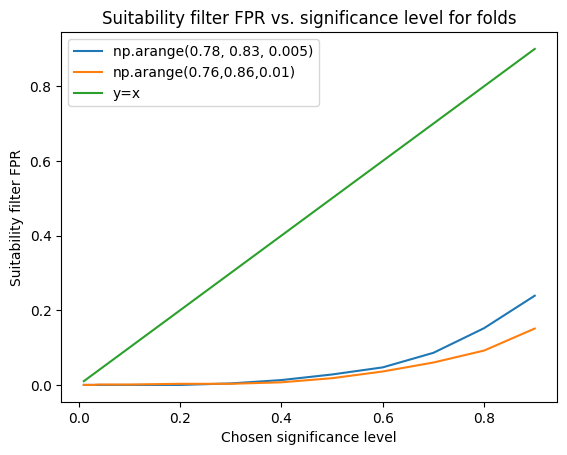

In [63]:
sig_level = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.plot(sig_level, fprs, label="np.arange(0.78, 0.83, 0.005)")
plt.plot(sig_level, fprs_old, label="np.arange(0.76,0.86,0.01)")
plt.plot(sig_level, sig_level, label="y=x")
plt.xlabel("Chosen significance level")
plt.ylabel("Suitability filter FPR")
plt.title("Suitability filter FPR vs. significance level for folds")
plt.legend()
plt.show()

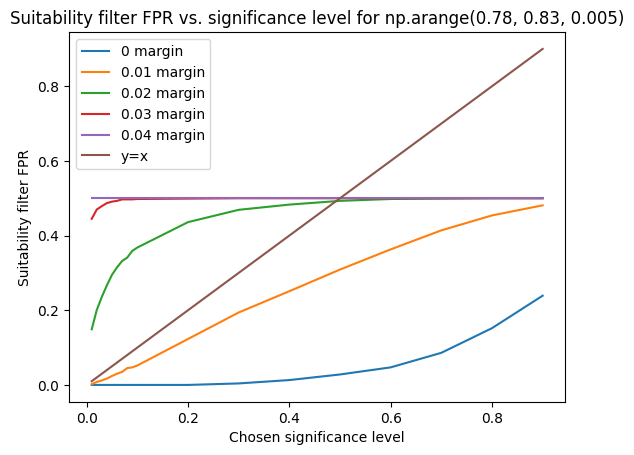

In [65]:
sig_level = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.plot(sig_level, fprs, label="0 margin")
plt.plot(sig_level, fprs_margin1, label="0.01 margin")
plt.plot(sig_level, fprs_margin2, label="0.02 margin")
plt.plot(sig_level, fprs_margin3, label="0.03 margin")
plt.plot(sig_level, fprs_margin4, label="0.04 margin")
plt.plot(sig_level, sig_level, label="y=x")
plt.xlabel("Chosen significance level")
plt.ylabel("Suitability filter FPR")
plt.title("Suitability filter FPR vs. significance level for np.arange(0.78, 0.83, 0.005)")
plt.legend()
plt.show()

In [19]:
x = []
yp01 = []
yp02 = []
yp03 = []
yp04 = []
yp05 = []
yp06 = []
yp07 = []
yp08 = []
yp09 = []
yp10 = []
yp20 = []
yp30 = []
yp40 = []
ya = []

for i in range(num_folds):
    x.append(corrs[:, i].mean())
    yp01.append(np.sum(p_vals[:, i] < 0.01))
    yp02.append(np.sum(p_vals[:, i] < 0.02))
    yp03.append(np.sum(p_vals[:, i] < 0.03))
    yp04.append(np.sum(p_vals[:, i] < 0.04))
    yp05.append(np.sum(p_vals[:, i] < 0.05))
    yp06.append(np.sum(p_vals[:, i] < 0.06))
    yp07.append(np.sum(p_vals[:, i] < 0.07))
    yp08.append(np.sum(p_vals[:, i] < 0.08))
    yp09.append(np.sum(p_vals[:, i] < 0.09))
    yp10.append(np.sum(p_vals[:, i] < 0.1))
    yp20.append(np.sum(p_vals[:, i] < 0.2))
    yp30.append(np.sum(p_vals[:, i] < 0.3))
    yp40.append(np.sum(p_vals[:, i] < 0.4))

    ya.append(np.sum(acs[:, i] > test_ac))

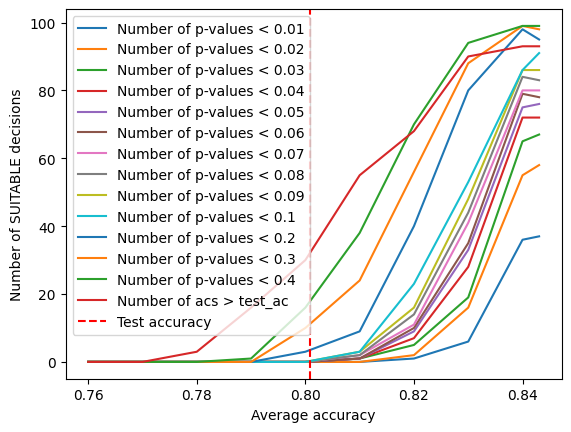

In [20]:
plt.plot(x, yp01, label="Number of p-values < 0.01")
plt.plot(x, yp02, label="Number of p-values < 0.02")
plt.plot(x, yp03, label="Number of p-values < 0.03")
plt.plot(x, yp04, label="Number of p-values < 0.04")
plt.plot(x, yp05, label="Number of p-values < 0.05")
plt.plot(x, yp06, label="Number of p-values < 0.06")
plt.plot(x, yp07, label="Number of p-values < 0.07")
plt.plot(x, yp08, label="Number of p-values < 0.08")
plt.plot(x, yp09, label="Number of p-values < 0.09")
plt.plot(x, yp10, label="Number of p-values < 0.1")
plt.plot(x, yp20, label="Number of p-values < 0.2")
plt.plot(x, yp30, label="Number of p-values < 0.3")
plt.plot(x, yp40, label="Number of p-values < 0.4")
plt.plot(x, ya, label="Number of acs > test_ac")
plt.xlabel("Average accuracy")
plt.ylabel("Number of SUITABLE decisions")
plt.axvline(test_corr, color='r', linestyle='--', label="Test accuracy")
plt.legend()
plt.show()

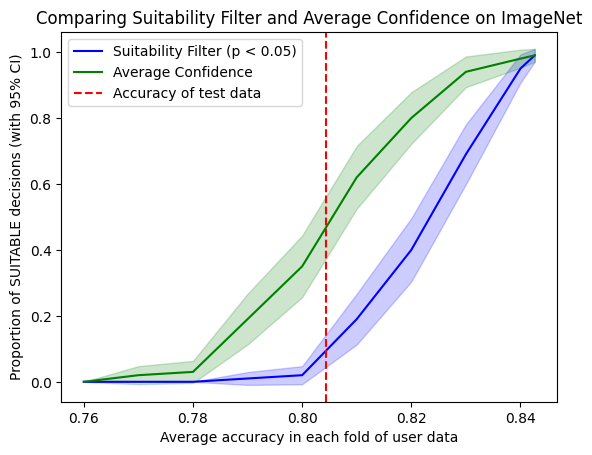

In [32]:
x = []
yp_mean = []
yp_ci = []
ya_mean = []
ya_ci = []

# Loop over folds to calculate the means and 95% CIs for each decision type
for i in range(num_folds):
    avg_accuracy = corrs[:, i].mean()
    x.append(avg_accuracy)

    # Significant p-values decision (p < 0.05)
    p_sig_decision = p_vals[:, i] < 0.05
    p_sig_mean = np.mean(p_sig_decision)
    p_sig_sem = np.std(p_sig_decision) / np.sqrt(len(p_sig_decision))
    p_sig_ci = 1.96 * p_sig_sem  # 95% confidence interval
    yp_mean.append(p_sig_mean)
    yp_ci.append(p_sig_ci)

    # Accuracy exceeds test_ac decision (acs > test_ac)
    ac_exceeds_test = acs[:, i] > test_ac
    ac_exceeds_mean = np.mean(ac_exceeds_test)
    ac_exceeds_sem = np.std(ac_exceeds_test) / np.sqrt(len(ac_exceeds_test))
    ac_exceeds_ci = 1.96 * ac_exceeds_sem  # 95% confidence interval
    ya_mean.append(ac_exceeds_mean)
    ya_ci.append(ac_exceeds_ci)

# Convert lists to arrays for fill_between to work
x = np.array(x)
yp_mean = np.array(yp_mean)
yp_ci = np.array(yp_ci)
ya_mean = np.array(ya_mean)
ya_ci = np.array(ya_ci)

# Plotting
plt.plot(x, yp_mean, label="Suitability Filter (p < 0.05)", color="blue")
plt.fill_between(x, yp_mean - yp_ci, yp_mean + yp_ci, color="blue", alpha=0.2)

plt.plot(x, ya_mean, label="Average Confidence", color="green")
plt.fill_between(x, ya_mean - ya_ci, ya_mean + ya_ci, color="green", alpha=0.2)

plt.xlabel("Average accuracy in each fold of user data")
plt.ylabel("Proportion of SUITABLE decisions (with 95% CI)")
plt.axvline(test_corr, color='r', linestyle='--', label="Accuracy of test data")
plt.title("Comparing Suitability Filter and Average Confidence on ImageNet")
plt.legend()
plt.show()

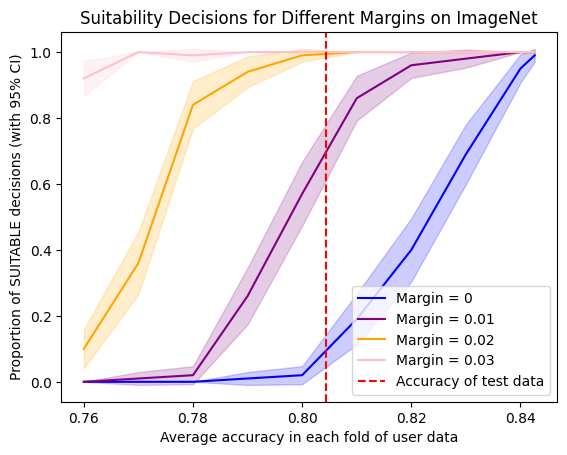

In [33]:
# Prepare lists to store results for each type of decision and margin
x = []
yp_mean = []
yp_ci = []
ya_mean = []
ya_ci = []
y_margin1_mean = []
y_margin1_ci = []
y_margin2_mean = []
y_margin2_ci = []
y_margin3_mean = []
y_margin3_ci = []
y_margin4_mean = []
y_margin4_ci = []

# Loop over folds to calculate the means and 95% CIs for each decision type
for i in range(num_folds):
    avg_accuracy = corrs[:, i].mean()
    x.append(avg_accuracy)

    # Significant p-values decision (p < 0.05)
    p_sig_decision = p_vals[:, i] < 0.05
    p_sig_mean = np.mean(p_sig_decision)
    p_sig_sem = np.std(p_sig_decision) / np.sqrt(len(p_sig_decision))
    p_sig_ci = 1.96 * p_sig_sem  # 95% confidence interval
    yp_mean.append(p_sig_mean)
    yp_ci.append(p_sig_ci)

    # Accuracy exceeds test_ac decision (acs > test_ac)
    ac_exceeds_test = acs[:, i] > test_ac
    ac_exceeds_mean = np.mean(ac_exceeds_test)
    ac_exceeds_sem = np.std(ac_exceeds_test) / np.sqrt(len(ac_exceeds_test))
    ac_exceeds_ci = 1.96 * ac_exceeds_sem
    ya_mean.append(ac_exceeds_mean)
    ya_ci.append(ac_exceeds_ci)

    # Margins 0.01 to 0.04
    for margin, mean_list, ci_list, p_values in zip(
        [p_vals_margin1, p_vals_margin2, p_vals_margin3, p_vals_margin4],
        [y_margin1_mean, y_margin2_mean, y_margin3_mean, y_margin4_mean],
        [y_margin1_ci, y_margin2_ci, y_margin3_ci, y_margin4_ci],
        [p_vals_margin1[:, i], p_vals_margin2[:, i], p_vals_margin3[:, i], p_vals_margin4[:, i]],
    ):
        margin_decision = p_values < 0.05
        margin_mean = np.mean(margin_decision)
        margin_sem = np.std(margin_decision) / np.sqrt(len(margin_decision))
        margin_ci = 1.96 * margin_sem
        mean_list.append(margin_mean)
        ci_list.append(margin_ci)

# Convert lists to arrays for fill_between to work
x = np.array(x)
yp_mean, yp_ci = np.array(yp_mean), np.array(yp_ci)
ya_mean, ya_ci = np.array(ya_mean), np.array(ya_ci)
y_margin1_mean, y_margin1_ci = np.array(y_margin1_mean), np.array(y_margin1_ci)
y_margin2_mean, y_margin2_ci = np.array(y_margin2_mean), np.array(y_margin2_ci)
y_margin3_mean, y_margin3_ci = np.array(y_margin3_mean), np.array(y_margin3_ci)
y_margin4_mean, y_margin4_ci = np.array(y_margin4_mean), np.array(y_margin4_ci)

# Plotting
plt.plot(x, yp_mean, label="Margin = 0", color="blue")
plt.fill_between(x, yp_mean - yp_ci, yp_mean + yp_ci, color="blue", alpha=0.2)

plt.plot(x, y_margin1_mean, label="Margin = 0.01", color="purple")
plt.fill_between(x, y_margin1_mean - y_margin1_ci, y_margin1_mean + y_margin1_ci, color="purple", alpha=0.2)

plt.plot(x, y_margin2_mean, label="Margin = 0.02", color="orange")
plt.fill_between(x, y_margin2_mean - y_margin2_ci, y_margin2_mean + y_margin2_ci, color="orange", alpha=0.2)

plt.plot(x, y_margin3_mean, label="Margin = 0.03", color="pink")
plt.fill_between(x, y_margin3_mean - y_margin3_ci, y_margin3_mean + y_margin3_ci, color="pink", alpha=0.2)

# plt.plot(x, y_margin4_mean, label="Margin = 0.04", color="cyan")
# plt.fill_between(x, y_margin4_mean - y_margin4_ci, y_margin4_mean + y_margin4_ci, color="cyan", alpha=0.2)

plt.xlabel("Average accuracy in each fold of user data")
plt.ylabel("Proportion of SUITABLE decisions (with 95% CI)")
plt.axvline(test_corr, color='r', linestyle='--', label="Accuracy of test data")
plt.title("Suitability Decisions for Different Margins on ImageNet")
plt.legend()
plt.show()


#### Baselines comparison

In [ ]:
# Construct suitability filter
num_random_tries = 100
target_accuracies = np.arange(0.78, 0.83, 0.005) 
num_acc_folds = len(target_accuracies)
target_sample_sizes = np.array([1000, 1500, 2000, 2500])
num_sample_folds = len(target_sample_sizes)
target_margins = np.array([0, 0.001, 0.005, 0.01, 0.015, 0.02])
num_margin_folds = len(target_margins)

corrs = np.zeros((num_random_tries, num_acc_folds))
p_vals = np.zeros((num_random_tries, num_acc_folds, num_sample_folds, num_margin_folds))
ac = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
atc = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
doc = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))


for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(all_user_corr, target_accuracies=target_accuracies)
    corrs[j] = np.array(actual_accuracies)

    for i, fold_indices in enumerate(folds):
        user_features = all_user_features[fold_indices]

        user_conf = user_features[:, 1]
        user_corr = all_user_corr[fold_indices]

        for s, num_samples in enumerate(target_sample_sizes):
            np.random.shuffle(user_features)
            ac[j, i, s] = average_confidence.binary_evaluation(user_confidences=user_conf[:num_samples])
            atc[j, i, s] = average_threshold_confidence.binary_evaluation(user_confidences=user_conf[:num_samples])
            doc[j, i, s] = difference_of_confidence.binary_evaluation(user_confidences=user_conf[:num_samples])

            for m, margin in enumerate(target_margins):
                test = suitability_filter.suitability_test(user_features=user_features[:num_samples], margin=margin)
                p_vals[j, i, s, m] = test['p_value']

/tmp/ipykernel_2981166/3984290046.py:10: RuntimeWarning: invalid value encountered in scalar divide
  fpr = np.sum(np.logical_and(decisions == 1, ground_truth == 0)) / np.sum(ground_truth == 0)


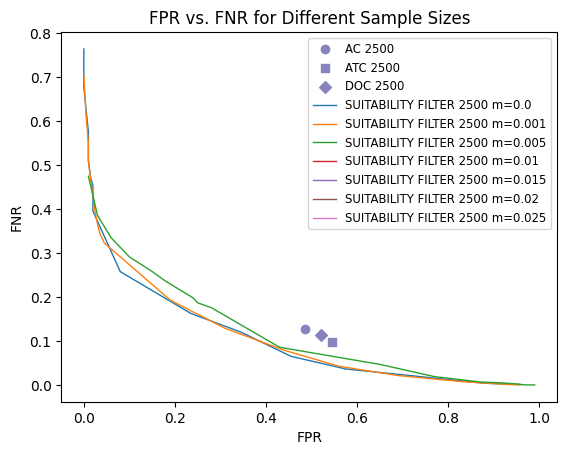

In [ ]:
# Color maps for each sample size
colors = plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples
markers = ['o', 's', 'D']  # Circle for AC, square for ATC, diamond for DOC

# Construct ground truth
ground_truth = corrs >= np.mean(test_corr)

def get_fpr_fnr(decisions, ground_truth):
    decisions, ground_truth = decisions.flatten(), ground_truth.flatten()
    fpr = np.sum(np.logical_and(decisions == 1, ground_truth == 0)) / np.sum(ground_truth == 0)
    fnr = np.sum(np.logical_and(decisions == 0, ground_truth == 1)) / np.sum(ground_truth == 1)
    return fpr, fnr

for s, num_samples in enumerate(target_sample_sizes):
    if num_samples < 2500:
        continue
    # Select color based on sample size
    color = colors[s](0.6)  # Adjust the hue to your preference

    # Plot each method with a different marker
    fpr_fnr_ac = get_fpr_fnr(ac[:, :, s], ground_truth)
    plt.scatter(*fpr_fnr_ac, label=f"AC {num_samples}", color=color, marker=markers[0])
    
    fpr_fnr_atc = get_fpr_fnr(atc[:, :, s], ground_truth)
    plt.scatter(*fpr_fnr_atc, label=f"ATC {num_samples}", color=color, marker=markers[1])
    
    fpr_fnr_doc = get_fpr_fnr(doc[:, :, s], ground_truth)
    plt.scatter(*fpr_fnr_doc, label=f"DOC {num_samples}", color=color, marker=markers[2])

    # Plot suitability filter line for the sample size
    for m in range(num_margin_folds):
        sf_fpr = []
        sf_fnr = []
        ground_truth_m = corrs >= np.mean(test_corr) - target_margins[m]
        for sig_level in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            fpr, fnr = get_fpr_fnr(p_vals[:, :, s, m] < sig_level, ground_truth_m)
            sf_fpr.append(fpr)
            sf_fnr.append(fnr)
    
        plt.plot(sf_fpr, sf_fnr, linestyle='-', linewidth=1, label=f"SUITABILITY FILTER {num_samples} m={target_margins[m]}")

plt.xlabel("FPR")
plt.ylabel("FNR")
plt.title("FPR vs. FNR for Different Sample Sizes")
plt.legend(fontsize='small')
plt.show()

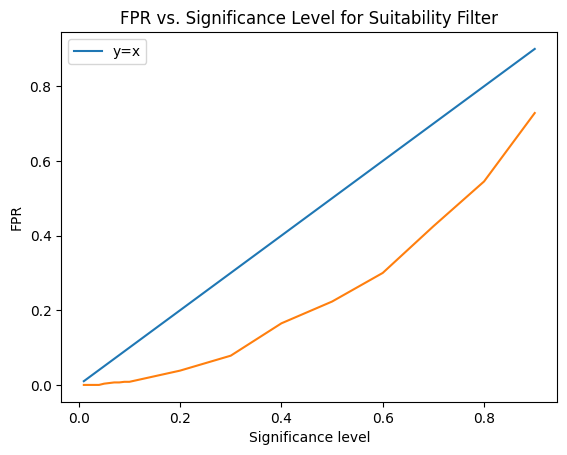

In [47]:
x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y = [get_fpr_fnr(p_vals[:, :, 3] < sig_level, ground_truth)[0] for sig_level in x]
plt.plot(x, x, label="y=x")
plt.plot(x, y)
plt.xlabel("Significance level")
plt.ylabel("FPR")
plt.legend()
plt.title("FPR vs. Significance Level for Suitability Filter")
plt.show()